# Monte Carlo Simulation for an Energy Equity (YPF)
**Author:** Mateo D. Williams | Bachelors SC on Physics & Data Science (UBA) - Physics & Data Science Master's student (UBA)

### 1. Goal
Model the stochastic evolution of **YPF** stock price over the next year (252 trading days) and quantify market risk (VaR).

### 2. Methodology & Assumptions
To make the calibration more representative, we set the following boundary conditions:

* **Time Window (Post‑pandemic):** we use historical data starting in **January 2022**.
  * *Rationale:* we exclude 2020–2021 to filter out the extreme, atypical COVID‑19 volatility and estimate parameters ($\mu$ and $\sigma$) that better reflect the current market regime.

* **Stochastic Model (Distribution):** we assume **Geometric Brownian Motion (GBM)**.
  * *Rationale:* we assume *log returns* are **Normally** distributed. Therefore, the code generates shocks using `norm.ppf` (standard normal). As a theoretical consequence, the simulated *prices* follow a **Log‑Normal** distribution (since $S_t>0$).

### 3. State Equation
The system evolves according to the stochastic differential equation:
$$dS_t = \mu S_t \, dt + \sigma S_t \, dW_t$$


In [1]:
import sqlite3
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.style.use('ggplot')

# Reproducibility (Monte Carlo randomness)
np.random.seed(42)

ticker = "YPF"

# DATA DOWNLOAD
data = yf.download(
    ticker,
    start="2020-01-01",
    end="2024-12-01",
    auto_adjust=False,
    multi_level_index=False
)["Adj Close"]

data = data.reset_index()
data.columns = ["Date", "Price"]
print("Historical price data downloaded.")


[*********************100%***********************]  1 of 1 completed

Historical price data downloaded.


In [2]:
# SQL FILTERING (SQLite ETL)

# Create a local DB
conn = sqlite3.connect("market_data.db")
data.to_sql("ypf_prices", conn, if_exists="replace", index=False)
print("Data saved to SQLite.")

# Filter from 2022 (post‑pandemic) to avoid extreme COVID volatility
# and obtain parameters that are more representative of the current market regime.
query = """
SELECT Date, Price
FROM ypf_prices
WHERE Date >= '2022-01-01'
ORDER BY Date ASC
"""

df_clean = pd.read_sql(query, conn, parse_dates=["Date"])
df_clean.set_index("Date", inplace=True)
conn.close()

print(f"Records: {len(df_clean)}")


Data saved to SQLite.
Records: 732


In [3]:
# MONTE CARLO SIMULATION (GBM)

# Model parameters (drift and volatility) from log returns
log_returns = np.log(1 + df_clean["Price"].pct_change())

mu = log_returns.mean()
var = log_returns.var()
sigma = log_returns.std()
drift = mu - (0.5 * var)

# Monte Carlo configuration
t_intervals = 252  # trading days
iterations = 1000
S0 = df_clean["Price"].iloc[-1]

# Simulated daily returns
daily_returns = np.exp(drift + sigma * norm.ppf(np.random.rand(t_intervals, iterations)))

# Initialize the price matrix
price_paths = np.zeros_like(daily_returns)
price_paths[0] = S0

# Time evolution: S(t) = S(t-1) * daily_return
for t in range(1, t_intervals):
    price_paths[t] = price_paths[t - 1] * daily_returns[t]

print(f"Simulation OK: {iterations} scenarios.")


Simulation OK: 1000 scenarios.


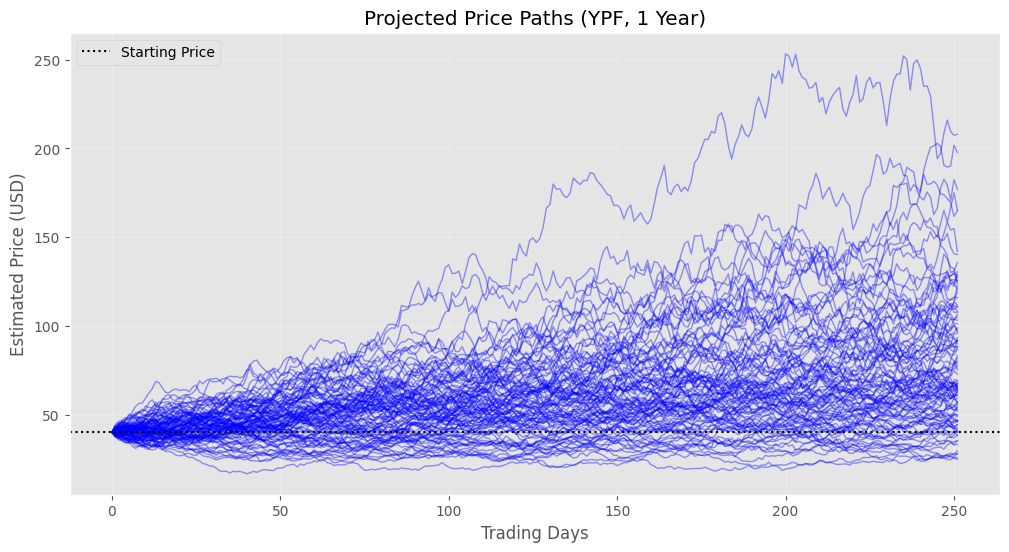

In [4]:
# SIMULATED PRICE PATHS

plt.figure(figsize=(12, 6))

# Plot only the first 100 paths to keep the figure readable
plt.plot(price_paths[:, :100], color="blue", alpha=0.4, linewidth=1)

# Starting price reference (dotted line)
plt.axhline(y=price_paths[0, 0], color="black", linestyle=":", label="Starting Price")

plt.title("Projected Price Paths (YPF, 1 Year)")
plt.xlabel("Trading Days")
plt.ylabel("Estimated Price (USD)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


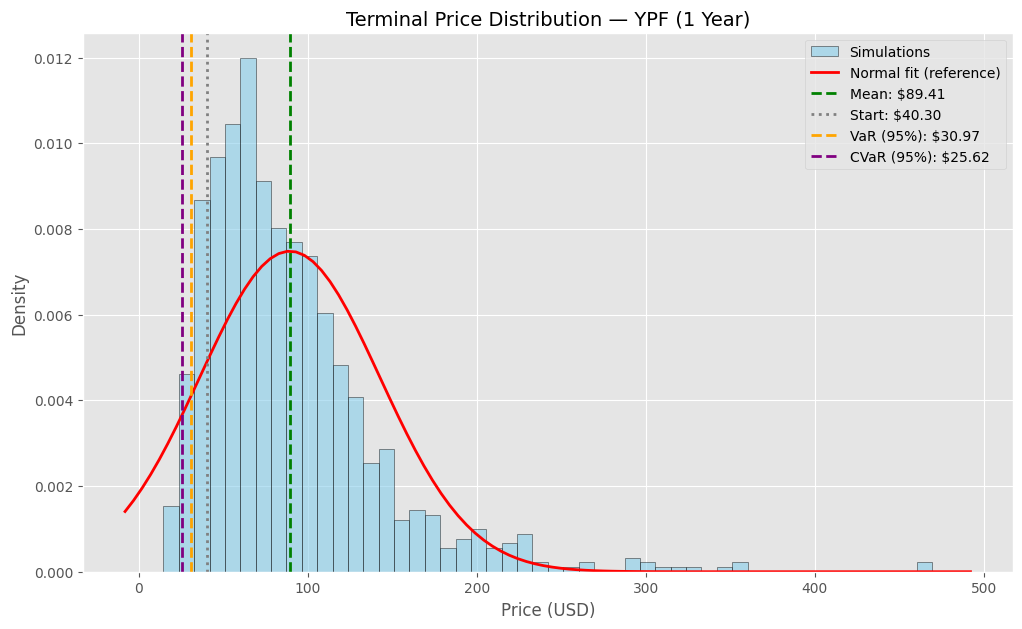

In [5]:
# TERMINAL DISTRIBUTION + RISK METRICS

# Variables for the plot
final_prices = price_paths[-1]
mean_final = np.mean(final_prices)
std_final = np.std(final_prices)
start_price = price_paths[0, 0]

# VaR(95%) as the 5th percentile of the terminal price distribution
var_95 = np.percentile(final_prices, 5)

# CVaR(95%) / Expected Shortfall: average of the worst 5% terminal prices
cvar_95 = final_prices[final_prices <= var_95].mean()

plt.figure(figsize=(12, 7))

# Histogram
plt.hist(final_prices, bins=50, density=True, alpha=0.6, color="skyblue",
         edgecolor="black", label="Simulations")

# Normal fit (reference only). Under GBM, terminal prices are theoretically log‑normal.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_final, std_final)
plt.plot(x, p, "r", linewidth=2, label="Normal fit (reference)")

# Reference lines
plt.axvline(mean_final, color="green", linestyle="dashed", linewidth=2, label=f"Mean: ${mean_final:.2f}")
plt.axvline(start_price, color="gray", linestyle="dotted", linewidth=2, label=f"Start: ${start_price:.2f}")
plt.axvline(var_95, color="orange", linestyle="dashed", linewidth=2, label=f"VaR (95%): ${var_95:.2f}")
plt.axvline(cvar_95, color="purple", linestyle="dashed", linewidth=2, label=f"CVaR (95%): ${cvar_95:.2f}")

plt.title("Terminal Price Distribution — YPF (1 Year)", fontsize=14)
plt.xlabel("Price (USD)")
plt.ylabel("Density")
plt.legend()
plt.show()


In [6]:
# RESULTS & INTERPRETATION

# Percentage of scenarios ending above the starting price
prob_profit = np.mean(final_prices > start_price) * 100

# Expected return (relative to the start price)
expected_return = ((mean_final - start_price) / start_price) * 100

print("-" * 35)
print("SIMULATION SUMMARY")
print("-" * 35)

print(f"Start price: ${start_price:.2f}")
print(f"Mean terminal price: ${mean_final:.2f}")

if mean_final > start_price:
    print(f"--> Expected change: +{expected_return:.2f}% (positive drift)")
else:
    print(f"--> Expected change: {expected_return:.2f}% (negative drift)")

print("\n" + "-" * 35)
print("RISK ANALYSIS")
print("-" * 35)

print("Under this GBM model, with 95% confidence,")
print(f"the terminal price is NOT expected to fall below: ${var_95:.2f} (VaR 95%)")
print(f"Average of the worst 5% terminal outcomes: ${cvar_95:.2f} (CVaR 95%)")

print("\n" + "-" * 35)
print("CONCLUSION")
print("-" * 35)
print(f"Out of {iterations} simulated scenarios, {prob_profit:.1f}% end with a profit.")


-----------------------------------
SIMULATION SUMMARY
-----------------------------------
Start price: $40.30
Mean terminal price: $89.41
--> Expected change: +121.85% (positive drift)

-----------------------------------
RISK ANALYSIS
-----------------------------------
Under this GBM model, with 95% confidence,
the terminal price is NOT expected to fall below: $30.97 (VaR 95%)
Average of the worst 5% terminal outcomes: $25.62 (CVaR 95%)

-----------------------------------
CONCLUSION
-----------------------------------
Out of 1000 simulated scenarios, 88.5% end with a profit.


### Methodological Conclusions

Regardless of the specific numerical result, the analysis supports three key takeaways about the asset’s behavior:

1. **Model sanity check:** The simulated paths behave consistently with the model assumptions. Using **Geometric Brownian Motion (GBM)** is a reasonable first‑order approximation for short‑horizon modeling when log‑returns are treated as approximately Gaussian.

2. **Risk quantification:** Unlike a single-point forecast, this approach allows us to compute **VaR (Value at Risk)**, turning qualitative uncertainty (“it might drop”) into a quantitative statement (“with 95% confidence, the terminal price floor is $X”), a standard metric in portfolio risk management.

3. **Limitations (next steps):** GBM assumes constant volatility ($\sigma$). For more realism—especially in emerging markets—future work could incorporate **time‑varying volatility** (e.g., GARCH) or **stochastic volatility** models (e.g., Heston) to better capture regime shifts and abrupt moves.
